# **Predictive Modelling Based on Sub Reddit Articles**

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import seaborn as sns 
import plotly
import plotly.express as px
import bs4
import requests
import nltk
import json

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer #fills missing values intelligently
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import set_config
set_config(display='diagram')
from sklearn import metrics; 
#usualmetrics - balanced_accuracy_score, accuracy_score, precision_score, classification_report, f1_score, confusion_matrix, roc_auc_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from imblearn.over_sampling import ADASYN, SMOTE

from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /home/nick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## A Jupyter -**Notebook with your analysis for a peer audience**- of data scientists.
### Below I am utilizing push shift api to collect a little over 300 posts for both of my selected Sub Reddits r/keto & r/Vegan. After I have all of the Data in a single Data Frame I will vectorize the words and use them to fit multiple predictive models to predict which posts come fro  which Sub Reddit.

In [48]:
def get_pushshift_data(start, end, subreddit, filt=False):
    url = 'https://api.pushshift.io/reddit/search/submission/'
    
    params = {'subreddit': subreddit,
              'size': 500,
              'after' : start,
              'before' : end,
              'filter' :['created_utc','subreddit', 'title', 'selftext', 'num_comments', 'score']}

    res = requests.get(url, params)
    data = res.json()
    posts = data['data']
    df = pd.DataFrame(posts)
    if filt == True:
        df = df[(df['selftext']!='[removed]')&(df['selftext']!='')&(df['selftext']!='[deleted]')]

    return df

In [49]:
keto2021 = get_pushshift_data('2021-01-01', '2021-10-16', 'keto', True)
keto2020 = get_pushshift_data('2020-01-01', '2020-12-31', 'keto', True)
keto2019 = get_pushshift_data('2019-01-01', '2019-12-31', 'keto', True)
keto2018 = get_pushshift_data('2018-01-01', '2018-12-31', 'keto', True)
keto2017 = get_pushshift_data('2017-01-01', '2017-12-31', 'keto', True)

In [50]:
ketodf = pd.concat([keto2021, keto2020, keto2019, keto2018, keto2017], axis=0).reset_index(drop=True)
ketodf

,created_utc,num_comments,score,selftext,subreddit,title
0,1609460100,9,1,"40 year old caucasian male, 5'11"", 200lbs)\n\n...",keto,High Cholesterol AND HS-CRP
1,1609461227,14,1,"I’m a 36 year old male, married, 3 kids and we...",keto,36 Male and BP too high
2,1609461881,7,1,I started in may of 2019 and today i weight 22...,keto,"New year, new goals, lets kick it this year."
3,1609463903,131,1,I use greenbeans as pasta constantly and my li...,keto,Why is NOBODY talking about green beans?
4,1609466161,30,1,Been keto since Jy 2020: previous post here \n...,keto,85lbs down. Thanks for your inspiration r/keto
...,...,...,...,...,...,...
367,1483310313,10,0,"Hey /r/keto,\n\nI'm looking to drop from ~210 ...",keto,Looking for some feedback on a diet I want to ...
368,1483311139,6,10,https://i.reddituploads.com/5500764c310545f3a9...,keto,Keto New Year's Resolution (x-post from r/mild...
369,1483311432,12,1,Hello fellow keto reddit friends. A few years...,keto,Increase muscle and lose body fat?
370,1483313733,6,0,I'm just about to start a ketogenic diet and I...,keto,Sodium and water intake


In [51]:
import time
time.sleep(2)

## **Must run twice**

In [52]:
vegan2021 = get_pushshift_data('2021-01-01', '2021-10-16', 'Vegan', True)
vegan2020 = get_pushshift_data('2020-01-01', '2020-12-31', 'Vegan', True)
vegan2019 = get_pushshift_data('2019-01-01', '2019-12-31', 'Vegan', True)
vegan2018 = get_pushshift_data('2018-01-01', '2018-12-31', 'Vegan', True)


In [53]:
time.sleep(2)

In [54]:
vegan2017 = get_pushshift_data('2017-01-01', '2017-12-31', 'Vegan', True)
vegan2016 = get_pushshift_data('2016-01-01', '2016-12-31', 'Vegan', True)
vegan2015 = get_pushshift_data('2015-01-01', '2015-12-31', 'Vegan', True)
vegan2014 = get_pushshift_data('2014-01-01', '2014-12-31', 'Vegan', True)

In [55]:
vegandf = pd.concat([vegan2021, vegan2020, vegan2019, vegan2018, vegan2017, vegan2016, vegan2015, vegan2014], axis=0).reset_index(drop=True)
vegandf

,created_utc,num_comments,score,selftext,subreddit,title
0,1609460201,2,1,So I am sure this year has been incredibly pai...,vegan,What a year this has been.
1,1609462282,32,1,"Unfortunately, since I had to move back in w/ ...",vegan,"So, starting my vegan lifestyle tomorrow. Just..."
2,1609462943,8,1,I am really into this cute vegan girl. She's s...,vegan,There's this cute vegan girl I like
3,1609464059,28,1,If you don't upvote it then you're not a vegan,vegan,Upvote this post if you're vegan
4,1609464994,5,1,"I don’t touch animal products much in my diet,...",vegan,2021 is my year!
...,...,...,...,...,...,...
328,1389035068,18,60,Last year I was a cashier at a gas station. I ...,vegan,Open Letter to a Former Customer: Thank You!
329,1389040996,34,6,So.. I've only been vegan for a few weeks and ...,vegan,Drunk Vegan Problems
330,1389053502,79,11,"Father, Entrepreneur, Playful \n*Edit - Love t...",vegan,"Let's see who we are. Beside vegan, describe y..."
331,1389063698,15,2,"So first, I tried making a white bean soup, th...",vegan,My homemade soups suck... help me.


In [56]:
finaldf = pd.concat([ketodf, vegandf])

In [57]:
finaldf['is_keto']=np.where(finaldf['subreddit']=='keto', 1, 0)
finaldf

,created_utc,num_comments,score,selftext,subreddit,title,is_keto
0,1609460100,9,1,"40 year old caucasian male, 5'11"", 200lbs)\n\n...",keto,High Cholesterol AND HS-CRP,1
1,1609461227,14,1,"I’m a 36 year old male, married, 3 kids and we...",keto,36 Male and BP too high,1
2,1609461881,7,1,I started in may of 2019 and today i weight 22...,keto,"New year, new goals, lets kick it this year.",1
3,1609463903,131,1,I use greenbeans as pasta constantly and my li...,keto,Why is NOBODY talking about green beans?,1
4,1609466161,30,1,Been keto since Jy 2020: previous post here \n...,keto,85lbs down. Thanks for your inspiration r/keto,1
...,...,...,...,...,...,...,...
328,1389035068,18,60,Last year I was a cashier at a gas station. I ...,vegan,Open Letter to a Former Customer: Thank You!,0
329,1389040996,34,6,So.. I've only been vegan for a few weeks and ...,vegan,Drunk Vegan Problems,0
330,1389053502,79,11,"Father, Entrepreneur, Playful \n*Edit - Love t...",vegan,"Let's see who we are. Beside vegan, describe y...",0
331,1389063698,15,2,"So first, I tried making a white bean soup, th...",vegan,My homemade soups suck... help me.,0


In [58]:
finaldf = finaldf.reset_index(drop=True)
finaldf

,created_utc,num_comments,score,selftext,subreddit,title,is_keto
0,1609460100,9,1,"40 year old caucasian male, 5'11"", 200lbs)\n\n...",keto,High Cholesterol AND HS-CRP,1
1,1609461227,14,1,"I’m a 36 year old male, married, 3 kids and we...",keto,36 Male and BP too high,1
2,1609461881,7,1,I started in may of 2019 and today i weight 22...,keto,"New year, new goals, lets kick it this year.",1
3,1609463903,131,1,I use greenbeans as pasta constantly and my li...,keto,Why is NOBODY talking about green beans?,1
4,1609466161,30,1,Been keto since Jy 2020: previous post here \n...,keto,85lbs down. Thanks for your inspiration r/keto,1
...,...,...,...,...,...,...,...
700,1389035068,18,60,Last year I was a cashier at a gas station. I ...,vegan,Open Letter to a Former Customer: Thank You!,0
701,1389040996,34,6,So.. I've only been vegan for a few weeks and ...,vegan,Drunk Vegan Problems,0
702,1389053502,79,11,"Father, Entrepreneur, Playful \n*Edit - Love t...",vegan,"Let's see who we are. Beside vegan, describe y...",0
703,1389063698,15,2,"So first, I tried making a white bean soup, th...",vegan,My homemade soups suck... help me.,0


In [59]:
words = finaldf['title']+finaldf['selftext']

In [60]:
finaldf['allwords']=words
finaldf = finaldf.dropna()

In [61]:
finaldf.to_csv('./data/finaldf.csv')
finaldf.head(2)

,created_utc,num_comments,score,selftext,subreddit,title,is_keto,allwords
0,1609460100,9,1,"40 year old caucasian male, 5'11"", 200lbs)\n\n...",keto,High Cholesterol AND HS-CRP,1,High Cholesterol AND HS-CRP40 year old caucasi...
1,1609461227,14,1,"I’m a 36 year old male, married, 3 kids and we...",keto,36 Male and BP too high,1,"36 Male and BP too highI’m a 36 year old male,..."


In [62]:
X = finaldf['allwords']

X_lem = []
for post in X:
    X_lem.append(' '.join([WordNetLemmatizer().lemmatize(i) for i in post.split()]))
    
X_stem = []
for post in X:
    X_stem.append(' '.join([PorterStemmer().stem(i) for i in post.split()]))

In [63]:
y = finaldf['is_keto']

In [64]:
cvect = CountVectorizer(stop_words='english', max_features=1000, token_pattern="[\w']+|\$[\d\.]+")
Xdf = pd.DataFrame(cvect.fit_transform(X).todense(), columns=cvect.get_feature_names_out())
Xdf.to_csv('./data/feats.csv')
Xdf

,0,01,1,10,100,12,15,16,17,18,...,year's,years,yeast,yes,yesterday,you're,you've,youtube,zero,zoos
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
cvect1 = CountVectorizer(stop_words='english', max_features=1000, token_pattern="[\w']+|\$[\d\.]+")
Xlemdf = pd.DataFrame(cvect1.fit_transform(X_lem).todense(), columns=cvect1.get_feature_names_out())
Xlemdf.to_csv('./data/lemfeats.csv')
Xlemdf

,0,01,1,10,100,12,15,16,17,18,...,year's,years,yeast,yes,yesterday,you're,you've,youtube,zero,zoos
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
cvect2 = CountVectorizer(stop_words='english', max_features=1000, token_pattern="[\w']+|\$[\d\.]+")
Xstemdf = pd.DataFrame(cvect2.fit_transform(X_stem).todense(), columns=cvect2.get_feature_names_out())
Xstemdf.to_csv('./data/stemfeats.csv')
Xstemdf

,0,01,1,10,100,12,15,16,17,18,...,y,year,year',years,yeast,yesterday,you'r,you'v,youtube,zero
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Create and compared 5 Models Below**. 
### I have modeled **3 Logistic Regression Classifiers** using the plain text vectorized, lemmatized text vectorized, and stemmed text vectorized. 
### After, I also try **2 Multinomial Naive Bayes Clssifiers** using Lemmatized and Stemmed Text.

In [67]:
def Categorical_Scores(y_test, predictions):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    acc = metrics.accuracy_score(y_test, predictions)
    sensi = tp/(fn+tp)
    speci = tn/(fp+tn)
    preci = metrics.precision_score(y_test, predictions)

    return {'Accuracy Score':acc, 'Sensitivity Score':sensi, 'Specificity Score':speci, 'Precision Score':preci, 'Average Score':round(sum([acc, sensi, speci, preci])/4, 5)}

### **Vectorized Logistic Regression Model**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y, random_state=4)

In [69]:
log = LogisticRegression()
log.fit(X_train, y_train)
log_preds = log.predict(X_test)
log_scores = Categorical_Scores(y_test, log_preds)
log_scores

{'Accuracy Score': 0.9602272727272727,
 'Sensitivity Score': 0.9387755102040817,
 'Specificity Score': 0.9871794871794872,
 'Precision Score': 0.989247311827957,
 'Average Score': 0.96886}

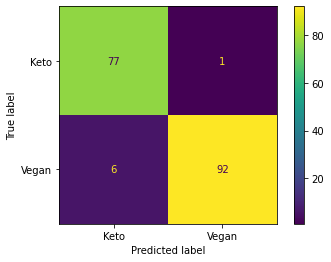

In [70]:
metrics.ConfusionMatrixDisplay.from_estimator( log, X_test, y_test, display_labels=['Keto', 'Vegan']);

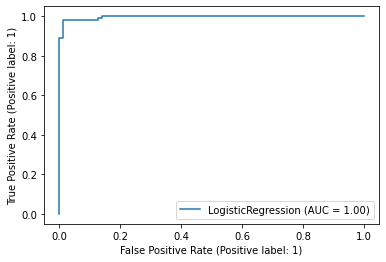

In [71]:
metrics.RocCurveDisplay.from_estimator(log, X_test, y_test);

### **Lemmatized Logistic Regression**

In [72]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xlemdf, y, random_state=4)

In [73]:
lemlog = LogisticRegression()
lemlog.fit(X_train1, y_train1)
lemlog_preds = lemlog.predict(X_test1)
lemlog_scores = Categorical_Scores(y_test1, lemlog_preds)
lemlog_scores

{'Accuracy Score': 0.9715909090909091,
 'Sensitivity Score': 0.9591836734693877,
 'Specificity Score': 0.9871794871794872,
 'Precision Score': 0.9894736842105263,
 'Average Score': 0.97686}

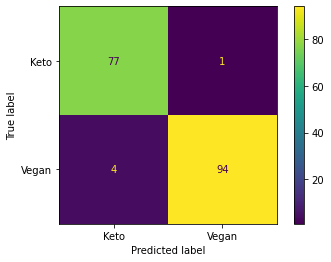

In [74]:
pd
metrics.ConfusionMatrixDisplay.from_estimator( lemlog, X_test1, y_test1, display_labels=['Keto', 'Vegan']);

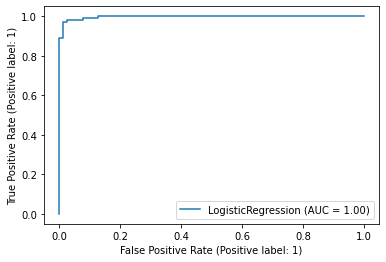

In [75]:
metrics.RocCurveDisplay.from_estimator(lemlog, X_test1, y_test1);

### **Stemmed Logistic Regression**

In [76]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xstemdf, y, random_state=4)

In [77]:
stemlog = LogisticRegression() 
stemlog.fit(X_train2, y_train2)  
stemlog_preds = stemlog.predict(X_test2)  
stemlog_scores = Categorical_Scores(y_test2, stemlog_preds)  
stemlog_scores

{'Accuracy Score': 0.9545454545454546,
 'Sensitivity Score': 0.9387755102040817,
 'Specificity Score': 0.9743589743589743,
 'Precision Score': 0.9787234042553191,
 'Average Score': 0.9616}

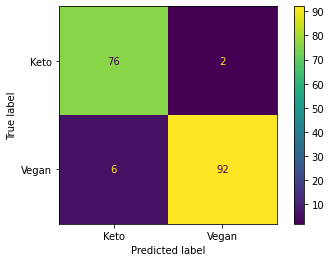

In [78]:
metrics.ConfusionMatrixDisplay.from_estimator( stemlog, X_test2, y_test2, display_labels=['Keto', 'Vegan']);

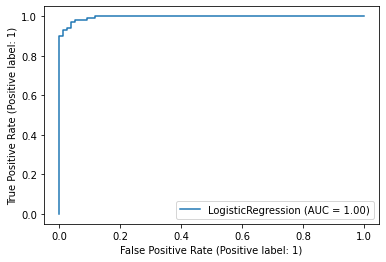

In [79]:
metrics.RocCurveDisplay.from_estimator(stemlog, X_test2, y_test2);

### **Lemmatized Multinomial Naive Bayes Model**

In [80]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(Xlemdf, y, random_state=4)

In [81]:
LemMultiNB = MultinomialNB()
LemMultiNB.fit(X_train3, y_train3)  
LemMultiNB_preds = LemMultiNB.predict(X_test3)  
LemMultiNB_scores = Categorical_Scores(y_test3, LemMultiNB_preds)  
LemMultiNB_scores

{'Accuracy Score': 0.9431818181818182,
 'Sensitivity Score': 0.9081632653061225,
 'Specificity Score': 0.9871794871794872,
 'Precision Score': 0.9888888888888889,
 'Average Score': 0.95685}

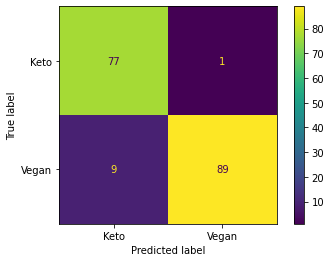

In [82]:
metrics.ConfusionMatrixDisplay.from_estimator( LemMultiNB, X_test3, y_test3, display_labels=['Keto', 'Vegan']);

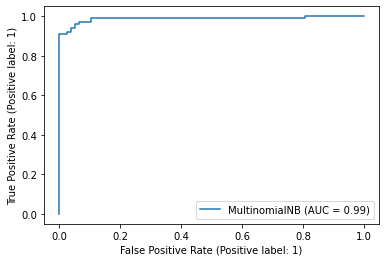

In [83]:
metrics.RocCurveDisplay.from_estimator(LemMultiNB, X_test3, y_test3);

### **Stemmed Multinomial Naive Bayes Model**

In [84]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(Xstemdf, y, random_state=4)

In [85]:
StemMultiNB = MultinomialNB()
StemMultiNB.fit(X_train4, y_train4)  
StemMultiNB_preds = StemMultiNB.predict(X_test4)  
StemMultiNB_scores = Categorical_Scores(y_test4, StemMultiNB_preds)  
[round(i, 5) for i in StemMultiNB_scores.values()]

[0.95455, 0.92857, 0.98718, 0.98913, 0.96486]

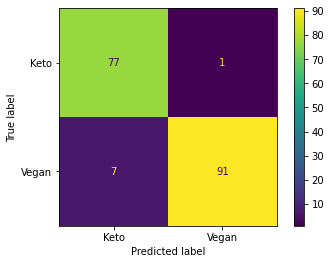

In [86]:
metrics.ConfusionMatrixDisplay.from_estimator( StemMultiNB, X_test4, y_test4, display_labels=['Keto', 'Vegan']);

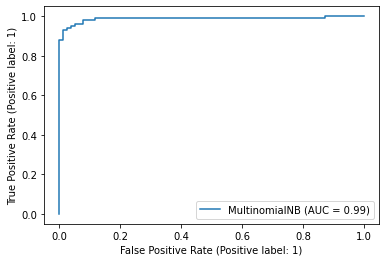

In [87]:
metrics.RocCurveDisplay.from_estimator(StemMultiNB, X_test4, y_test4);

In [88]:
coef_df = pd.DataFrame(lemlog.coef_, columns=[i for i in lemlog.feature_names_in_]).T
coef_df['std']=X_train.std()
coef_df.columns = ['coef', 'std']
coef_df

,coef,std
0,-0.071640,0.251932
01,0.000303,0.245595
1,0.272198,1.249656
10,-0.103705,0.314591
100,-0.108617,0.277524
...,...,...
you're,-0.135690,0.510833
you've,-0.000119,0.162435
youtube,0.133698,0.194401
zero,0.476116,0.245595


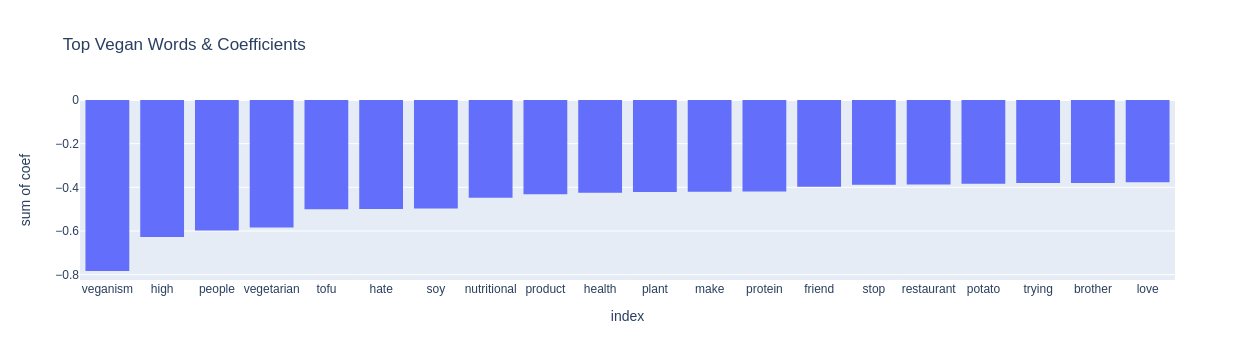

In [89]:
topvegan = coef_df.loc[coef_df['coef'].sort_values()[2:22].index]
topvegan
px.histogram(data_frame=topvegan, x=topvegan.index, y='coef', title='Top Vegan Words & Coefficients')

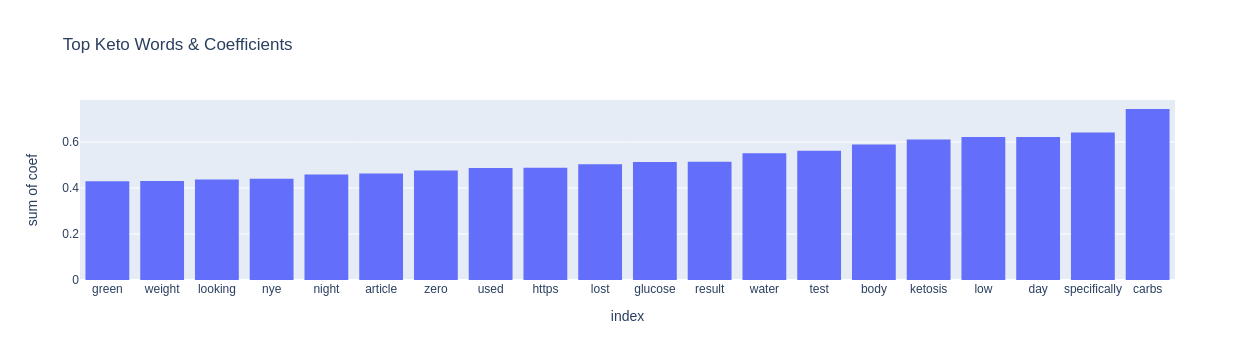

In [90]:
topketo = coef_df.loc[coef_df['coef'].sort_values(ascending=True)[-21:-1].index]
px.histogram(data_frame=topketo, x=topketo.index, y='coef', title='Top Keto Words & Coefficients')